<a href="https://colab.research.google.com/github/Affan009/bitcoin_trading_strategy/blob/main/bitcoin_trading_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [2]:
!pip install scikeras --quiet

In [3]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from keras.optimizers import SGD

import yfinance as yf
import datetime as dt

# Setting Time Range

In [4]:
start = dt.datetime(2015,1,1)
end = dt.datetime(2024, 12, 31)

# Fetching Bitcoin Data

In [5]:
btc = yf.download('BTC-USD', start=start, end=end)
btc.columns = btc.columns.get_level_values(0)

/tmp/ipython-input-5-3917247231.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download('BTC-USD', start=start, end=end)
[*********************100%***********************]  1 of 1 completed


# Exploratory Analysis

In [6]:
btc.shape

(3652, 5)

In [7]:
btc

Price,Close,High,Low,Open,Volume
Date,,,,,
2015-01-01,314.248993,320.434998,314.002991,320.434998,8036550
2015-01-02,315.032013,315.838989,313.565002,314.079010,7860650
2015-01-03,281.082001,315.149994,281.082001,314.846008,33054400
2015-01-04,264.195007,287.230011,257.612000,281.145996,55629100
2015-01-05,274.473999,278.341003,265.084015,265.084015,43962800
...,...,...,...,...,...
2024-12-26,95795.515625,99884.570312,95137.882812,99297.695312,47054980873
2024-12-27,94164.859375,97294.843750,93310.742188,95704.976562,52419934565
2024-12-28,95163.929688,95525.898438,94014.289062,94160.187500,24107436185


In [8]:
btc.describe()

Price,Close,High,Low,Open,Volume
count,3652.000000,3652.000000,3652.000000,3652.000000,3.652000e+03
mean,20123.565263,20552.052714,19627.496007,20099.585686,1.911481e+10
std,22168.020125,22625.655408,21637.605597,22139.908043,2.038432e+10
min,178.102997,211.731003,171.509995,176.897003,7.860650e+06
25%,2586.177429,2677.407532,2510.414978,2576.480042,1.181818e+09
50%,9665.131836,9829.667969,9459.360840,9664.111328,1.548866e+10
75%,32142.020020,33301.115234,30768.688477,32131.774414,3.020977e+10
max,106140.601562,108268.445312,105291.734375,106147.296875,3.509679e+11


# Cleaning and Preparing Data

In [9]:
print('Null Values =', btc.isnull().values.any())

Null Values = False


# Creating Labels for the Data

In [10]:
btc['short_mavg'] = btc['Close'].rolling(window=10, min_periods=1, center=False).mean()

btc['long_mavg'] = btc['Close'].rolling(window=60, min_periods=1, center=False).mean()

btc['signal'] = np.where(btc['short_mavg'] > btc['long_mavg'], 1.0, 0.0)

In [11]:
btc

Price,Close,High,Low,Open,Volume,short_mavg,long_mavg,signal
Date,,,,,,,,
2015-01-01,314.248993,320.434998,314.002991,320.434998,8036550,314.248993,314.248993,0.0
2015-01-02,315.032013,315.838989,313.565002,314.079010,7860650,314.640503,314.640503,0.0
2015-01-03,281.082001,315.149994,281.082001,314.846008,33054400,303.454336,303.454336,0.0
2015-01-04,264.195007,287.230011,257.612000,281.145996,55629100,293.639503,293.639503,0.0
2015-01-05,274.473999,278.341003,265.084015,265.084015,43962800,289.806403,289.806403,0.0
...,...,...,...,...,...,...,...,...
2024-12-26,95795.515625,99884.570312,95137.882812,99297.695312,47054980873,98221.573438,90976.569792,1.0
2024-12-27,94164.859375,97294.843750,93310.742188,95704.976562,52419934565,97023.999219,91380.854818,1.0
2024-12-28,95163.929688,95525.898438,94014.289062,94160.187500,24107436185,96536.238281,91754.912109,1.0


# Feature Engineering

In [12]:
# Exponential Moving Average
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
btc['EMA10'] = EMA(btc, 10)
btc['EMA30'] = EMA(btc, 30)
btc['EMA200'] = EMA(btc, 200)
btc.head()

# Rate of Change
def ROC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))
    return ROC
btc['ROC10'] = ROC(btc['Close'], 10)
btc['ROC30'] = ROC(btc['Close'], 30)

# Price Momentum
def MOM(df, n):
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM
btc['MOM10'] = MOM(btc['Close'], 10)
btc['MOM30'] = MOM(btc['Close'], 30)

# Relative Strength Index
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
btc['RSI10'] = RSI(btc['Close'], 10)
btc['RSI30'] = RSI(btc['Close'], 30)
btc['RSI200'] = RSI(btc['Close'], 200)

# Stochastic Oscillator
def STOK(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

btc['%K10'] = STOK(btc['Close'], btc['Low'], btc['High'], 10)
btc['%D10'] = STOD(btc['Close'], btc['Low'], btc['High'], 10)
btc['%K30'] = STOK(btc['Close'], btc['Low'], btc['High'], 30)
btc['%D30'] = STOD(btc['Close'], btc['Low'], btc['High'], 30)
btc['%K200'] = STOK(btc['Close'], btc['Low'], btc['High'], 200)
btc['%D200'] = STOD(btc['Close'], btc['Low'], btc['High'], 200)

# Moving Average
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
btc['MA21'] = MA(btc, 10)
btc['MA63'] = MA(btc, 30)
btc['MA252'] = MA(btc, 200)
btc

Price,Close,High,Low,Open,Volume,short_mavg,long_mavg,signal,EMA10,EMA30,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,314.248993,320.434998,314.002991,320.434998,8036550,314.248993,314.248993,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,315.032013,315.838989,313.565002,314.079010,7860650,314.640503,314.640503,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-03,281.082001,315.149994,281.082001,314.846008,33054400,303.454336,303.454336,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,264.195007,287.230011,257.612000,281.145996,55629100,293.639503,293.639503,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,274.473999,278.341003,265.084015,265.084015,43962800,289.806403,289.806403,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-26,95795.515625,99884.570312,95137.882812,99297.695312,47054980873,98221.573438,90976.569792,1.0,98005.135115,96976.320259,...,56.225209,22.495968,35.719425,24.359641,39.426332,78.912056,82.510005,98221.573438,98727.185156,70867.881836
2024-12-27,94164.859375,97294.843750,93310.742188,95704.976562,52419934565,97023.999219,91380.854818,1.0,97306.903163,96794.935686,...,55.862701,13.918292,26.893774,13.313601,28.804484,76.155111,79.967628,97023.999219,98667.262760,70991.144727
2024-12-28,95163.929688,95525.898438,94014.289062,94160.187500,24107436185,96536.238281,91754.912109,1.0,96917.271622,96689.709492,...,56.037236,28.267841,21.560701,19.454295,19.042512,77.844236,77.637134,96536.238281,98650.978125,71130.304219


In [13]:
# Removing unecessary columns
btc = btc.drop(['High','Low','Open', 'Volume','short_mavg','long_mavg'], axis=1)

In [14]:
btc.dropna(inplace=True)

In [15]:
btc

Price,Close,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,RSI10,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-21,275.833008,1.0,278.617937,269.376551,249.262676,-11.269770,11.677801,-17.281982,31.889008,50.650423,...,48.395696,8.949039,11.961884,47.910952,48.329250,72.628108,71.883772,283.710397,267.728732,246.636135
2015-07-22,277.221985,1.0,278.364127,269.882709,249.582939,-5.078513,13.477903,-33.645020,30.231979,52.011783,...,48.456070,13.311877,12.881008,49.787213,49.953826,73.984475,73.691698,280.345895,268.736464,246.616835
2015-07-23,276.049011,1.0,277.943197,270.280535,249.885643,-3.970925,14.774135,-16.004974,31.753006,50.699451,...,48.408002,16.619695,12.960204,48.202735,48.633633,73.163548,73.258710,278.745398,269.794898,246.676105
2015-07-24,288.278015,1.0,279.822255,271.441664,250.324100,0.856808,18.731140,0.814026,47.763016,61.850012,...,48.938736,76.562255,35.497942,64.721940,54.237296,81.722240,76.290088,278.826801,271.386998,246.745125
2015-07-25,288.696991,1.0,281.435843,272.554912,250.761692,3.814607,18.515644,2.867981,45.897995,62.175678,...,48.956817,87.011384,60.064445,64.721771,59.215482,82.015468,78.967085,279.113599,272.916932,246.757665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-26,95795.515625,1.0,98005.135115,96976.320259,75259.340997,-9.746587,-0.174043,-10234.203125,3810.195312,43.096484,...,56.225209,22.495968,35.719425,24.359641,39.426332,78.912056,82.510005,98221.573438,98727.185156,70867.881836
2024-12-27,94164.859375,1.0,97306.903163,96794.935686,75447.455608,-5.874240,-1.555223,-11975.742188,-1797.671875,39.466597,...,55.862701,13.918292,26.893774,13.313601,28.804484,76.155111,79.967628,97023.999219,98667.262760,70991.144727
2024-12-28,95163.929688,1.0,96917.271622,96689.709492,75643.639430,-2.386912,-2.357437,-4877.609375,-488.539062,42.749240,...,56.037236,28.267841,21.560701,19.454295,19.042512,77.844236,77.637134,96536.238281,98650.978125,71130.304219


# Visualizing Data

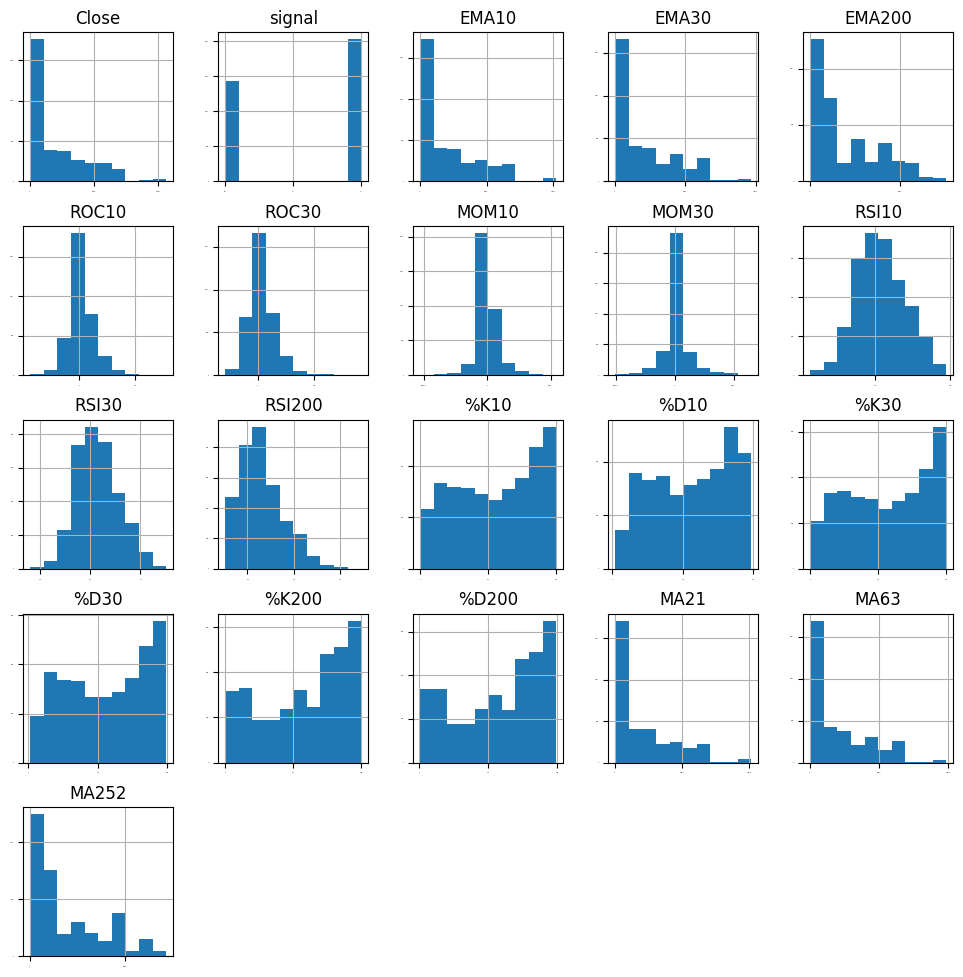

In [16]:
btc.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

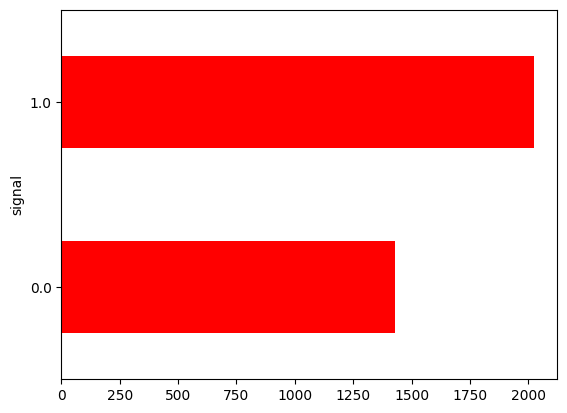

In [17]:
fig = plt.figure()
plot = btc.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

<Axes: title={'center': 'Correlation Matrix'}, xlabel='Price', ylabel='Price'>

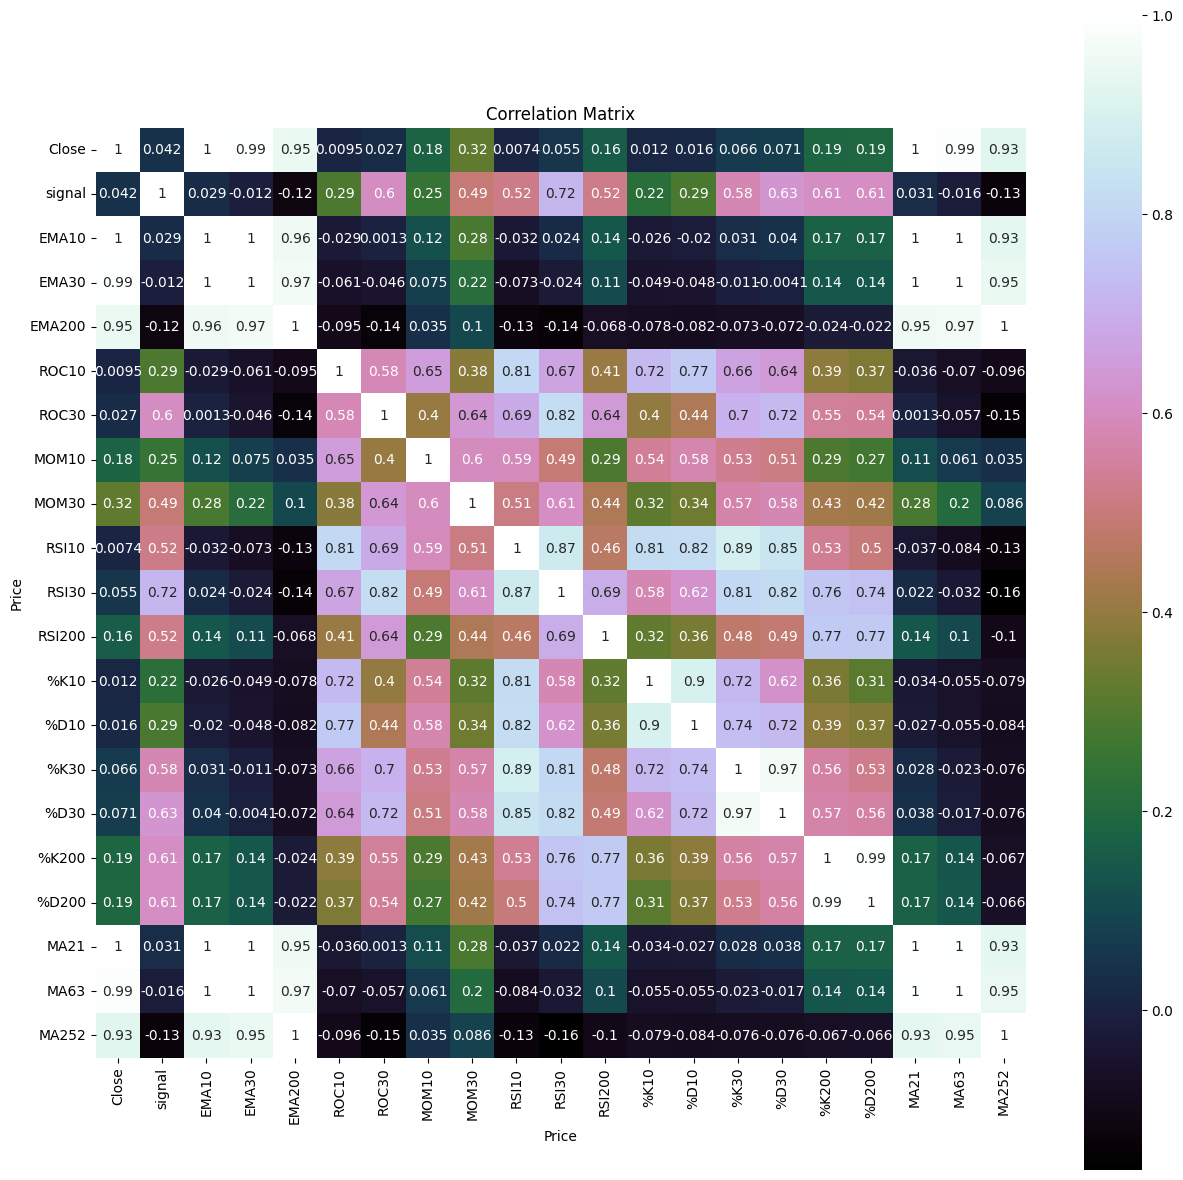

In [18]:
correlation = btc.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

# Train Test Split

In [19]:
Y= btc["signal"]
X = btc.loc[:, btc.columns != 'signal']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

In [20]:
num_folds = 10
seed = 7
scoring = 'accuracy'

In [21]:
# Models
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

In [22]:
# K-Fold Cross Validation
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.939493 (0.012345)
LDA: 0.910870 (0.015726)
KNN: 0.954348 (0.010526)
CART: 0.914493 (0.022170)
NB: 0.831522 (0.018492)
NN: 0.852174 (0.043953)
AB: 0.924638 (0.013342)
GBM: 0.944565 (0.013464)
RF: 0.951449 (0.013768)


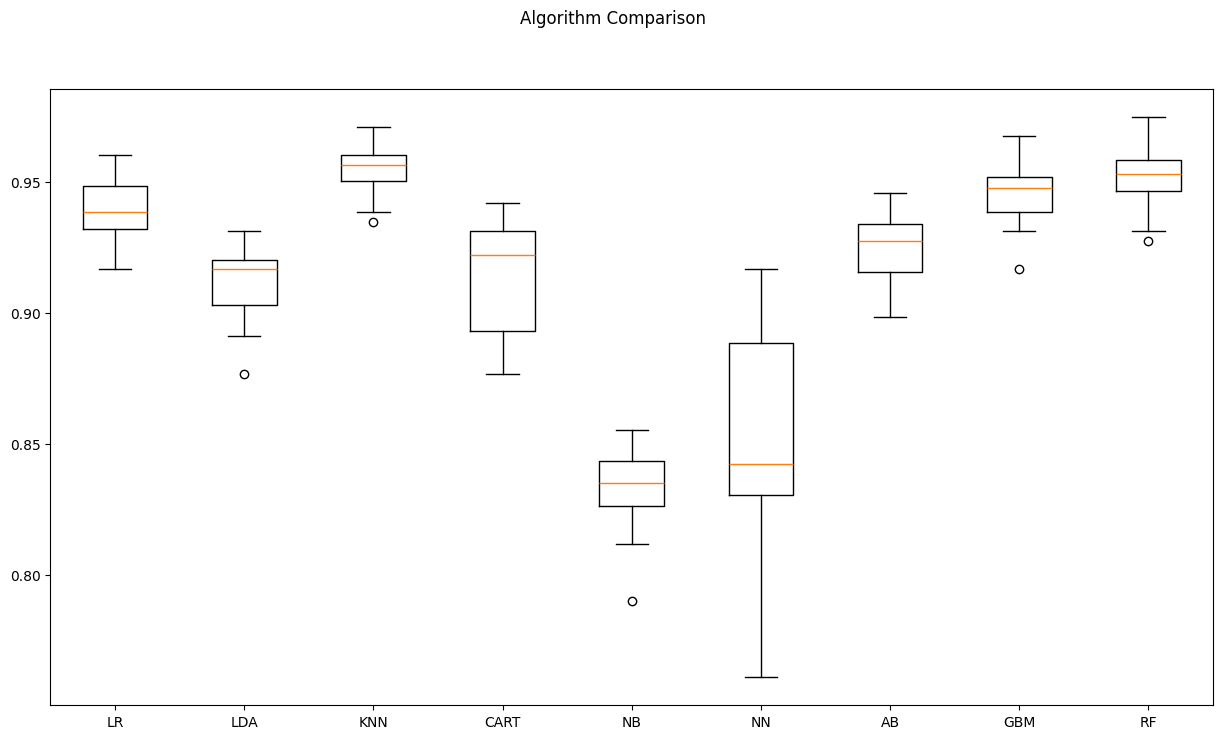

In [23]:
# Algorithm Comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

# Model Tuning

In [24]:
# Random Forest Model is choosen
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

# Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.955797 using {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#7 0.923913 (0.014402) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#5 0.927899 (0.011622) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#3 0.949275 (0.013749) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#2 0.952174 (0.015859) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#8 0.920652 (0.016077) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#6 0.926449 (0.012660) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#1 0.955797 (0.014200) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#4 0.949275 (0.018116) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


# Model Finalizing and Fitting

In [25]:
model = RandomForestClassifier(criterion='gini', n_estimators=80,max_depth=10,n_jobs=-1) # rbf is default kernel
model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=80, n_jobs=-1)

# Model Testing and Results

In [26]:
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9507959479015919
[[261  20]
 [ 14 396]]
              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94       281
         1.0       0.95      0.97      0.96       410

    accuracy                           0.95       691
   macro avg       0.95      0.95      0.95       691
weighted avg       0.95      0.95      0.95       691



<Axes: xlabel='Predicted', ylabel='Actual'>

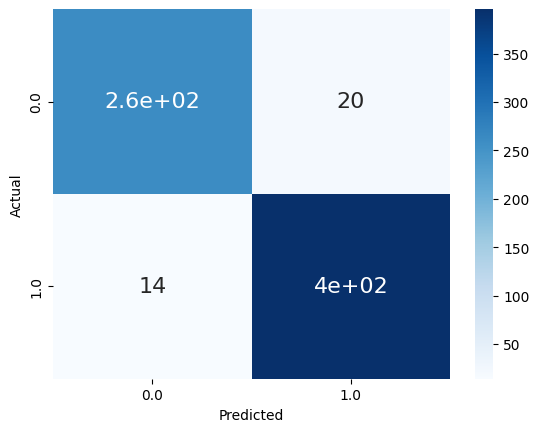

In [27]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

# Feature Importance

Text(0.5, 0, 'Variable Importance')

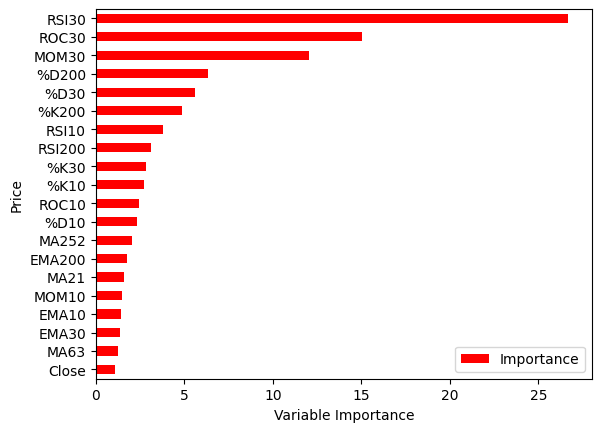

In [28]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

# Backtesting the Strategy

<Axes: >

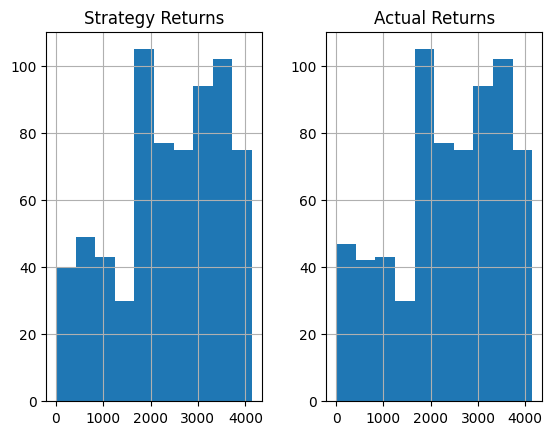

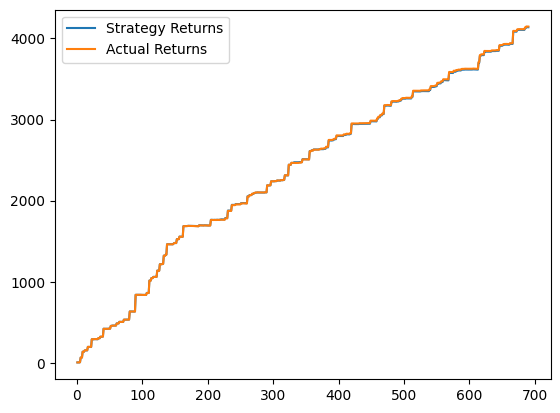

In [29]:
backtestdata = pd.DataFrame(index=X_validation.index)
backtestdata['signal_pred'] = predictions
backtestdata['signal_actual'] = Y_validation
backtestdata['Market Returns'] = X_validation['Close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata=backtestdata.reset_index()
backtestdata.head()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()

In [30]:
cumulative_strategy_returns = (1 + backtestdata['Strategy Returns']).cumprod()
cumulative_actual_returns = (1 + backtestdata['Actual Returns']).cumprod()

def sharpe_ratio(returns, risk_free_rate=0):
    excess_returns = returns - risk_free_rate
    return (excess_returns.mean() / excess_returns.std()) * np.sqrt(252)

sharpe_strategy = sharpe_ratio(backtestdata['Strategy Returns'])
sharpe_actual = sharpe_ratio(backtestdata['Actual Returns'])

print(f"Sharpe Ratio (Strategy): {sharpe_strategy:.2f}")
print(f"Sharpe Ratio (Actual): {sharpe_actual:.2f}")

Sharpe Ratio (Strategy): 4.41
Sharpe Ratio (Actual): 4.42
